In [1]:
import deepxde1 as dde
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Deepxde backend not selected or invalid. Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow



Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax (all lowercase)


2023-02-05 21:37:41.503400: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 21:37:41.503431: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def pde(x, y):
    dy_x = tf.gradients(y, x)[0]
    dy_x, dy_t = dy_x[:, 0:1], dy_x[:,1:2]
    dy_xx = tf.gradients(dy_x, x)[0][:, 0:1]
    return (dy_t + y*dy_x - 0.01/np.pi * dy_xx)

In [3]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 9.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [4]:
#bc = 0
bc = dde.DirichletBC(geomtime, lambda x:0, lambda _, on_boundary: on_boundary)

#ic = -sin(pi*x)
ic = dde.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

In [5]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain = 30000,
    num_boundary = 1000,
    num_initial = 2000
)

/home/ruslan/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+30002=30002. 
  warnings.warn("The balance properties of Sobol' points require "
/home/ruslan/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+1002=1002. 
  warnings.warn("The balance properties of Sobol' points require "
/home/ruslan/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2002=2002. 
  warnings.warn("The balance properties of Sobol' points require "


In [6]:
def gen_testdata():
    """
    Import and preprocess the dataset with the exact solution.
    """
    
    # Load the data:
    data = np.load('Burgers.npz')
    
    # Obtain the values for t, x, and the excat solution:
    t, x, exact = data["t"], data["x"], data["usol"].T
    
    # Process the data and flatten it out (like labels and features):
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    
    return X, y

Compiling model...
'compile' took 0.000424 s



2023-02-05 21:37:44.618161: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-05 21:37:44.618197: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-05 21:37:44.618223: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ruslan-Inspiron-5770): /proc/driver/nvidia/version does not exist
2023-02-05 21:37:44.618489: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training model...

Cause: could not parse the source code of <function <lambda> at 0x7f5f7da4a0d0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f5f7da4a0d0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f5f7da4a310>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f5

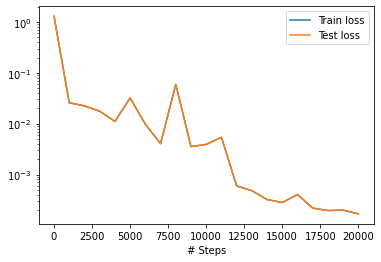

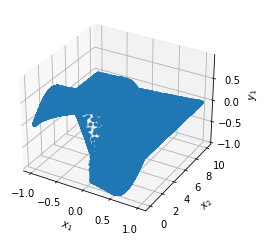

In [7]:
layers = [2] + [20]*3 +[1]

net = dde.maps.FNN(layers, "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("ngd", lr = 0.001)
losshistory, train_state = model.train(epochs = 20000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

In [8]:
x_data = np.linspace(-1, 1, num = 1000)
t_data = np.linspace(0, 1,num= 1000)
test_x, test_t = np.meshgrid(x_data, t_data)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_t))).T
predicted_solution = model.predict(test_domain)
residual = model.predict(test_domain, operator = pde)
predicted_solution = predicted_solution.reshape(1000, 1000)
residual = residual.reshape(1000, 1000)

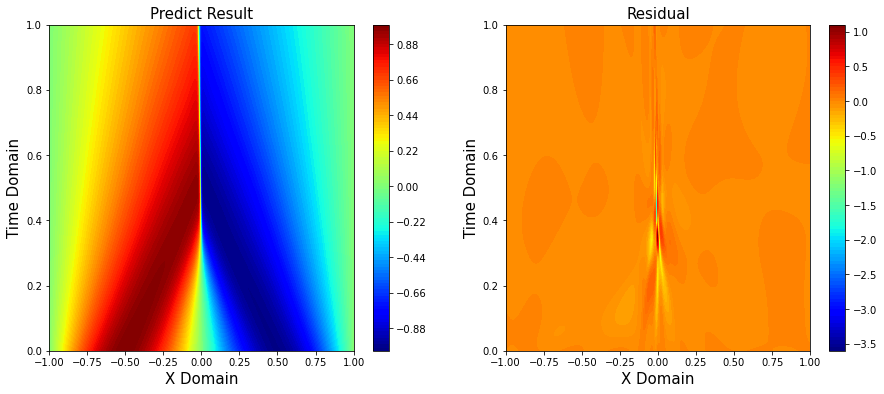

In [9]:
fig = plt.figure(figsize = (15, 6))
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Predict Result", fontsize = 15)
ax.set_xlabel("X Domain", fontsize = 15)
ax.set_ylabel("Time Domain", fontsize = 15)
cs = ax.contourf(x_data, t_data, predicted_solution, 100, cmap = "jet")
cbar = fig.colorbar(cs)

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Residual", fontsize = 15)
ax2.set_xlabel("X Domain", fontsize = 15)
ax2.set_ylabel("Time Domain", fontsize = 15)
cs2 = ax2.contourf(x_data, t_data, residual, 100, cmap = "jet")
cbar2 = fig.colorbar(cs2)

plt.show()

In [10]:
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

Mean residual: 0.0023394335
L2 relative error: 0.002720615434152
